# <span style="color:purple"> Markowitz solution: Evaluation of the most constervative call option price </span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pricing import EquityForwardCurve, ForwardVariance, DiscountingCurve,piecewise_function,Vanilla_PayOff,PricingModel
from scipy import exp, sqrt, log
from scipy.interpolate import interp1d
import lets_be_rational.LetsBeRational as lbr
import time, sys
from montecarlo import MC_Analisys, MC
from matplotlib import ticker
from targetvol import time_grid_union, Drift, CholeskyTDependent, Strategy,TVSForwardCurve ,TargetVolatilityStrategy,TargetVolatilityEuler,Markowitz_solution,loss_function
from numpy.linalg import cholesky

## Four Equities

#### market data

In [2]:
N_equity = 4                                #number of equities
T_max = 10
t = 0.                                      #pricing date
spot_price = np.array([110,120,97,133])            #spot price of the two assets
corr = np.array(([1,0.15,0.10,0.20],[0.15,1.,-0.05,0.18],[0.1,-0.05,1.,0.13],[0.20,0.18,0.13,1]))       #correlation matrix
minus = 1
"""Market Discount factors"""
r_t = np.array([1,1,1.9,1.2])/100            
T_discounts = np.array([0.,3,6.,T_max])      #data observation of the market discounts factor
market_discounts = exp(-r_t*T_discounts)       #market discounts factor

"""Market repo rates"""  #https://tradingeconomics.com/united-states/repo-rate
T_repo1 = np.array([2,6,T_max])       #data observation of the market repo rates for equity 1
repo_rate1 = minus*np.array([0.32,0.35,0.33])/100  #market repo rates for equity 1


T_repo2 = np.array([3.,6.,T_max])
repo_rate2 = minus*np.array([0.21,0.2,0.25])/100

T_repo3 = np.array([2.,5.,T_max])
repo_rate3 = minus*np.array([0.1,0.17,0.199])/100

T_repo4 = np.array([5,T_max])
repo_rate4 = minus*np.array([0.2,0.24])/100


for i in range(N_equity):                   #dimensional check between time and market data
    a = globals()["repo_rate" + str(i+1)]
    b = globals()["T_repo" + str(i+1)]
    if(a.shape!=b.shape):
        raise Exception("WARNING: Different dimension between data and value for repo rates of asset "+str(i+1))
        
"""Spot Volatilities"""
sigma1 = np.array([20,20.6,22])/100
T_sigma1 = np.array([2,5.,T_max])
K1 = np.array([spot_price[0],200])
spot_vola1 = np.array((sigma1,sigma1))                                      #market implied volatility matrix

sigma2 = np.array([30,31,32.62])/100
T_sigma2 =  np.array([2.,6,T_max])
K2 = np.array([spot_price[1],200])
spot_vola2 = np.array((sigma2,sigma2))  

sigma3 = np.array([25,23,22])/100
T_sigma3 = np.array([3,7.,T_max])
K3 = np.array([spot_price[2],200])
spot_vola3 = np.array((sigma3,sigma3))  

sigma4 = np.array([15,16,14])/100
T_sigma4 =  np.array([2,6.,T_max])
K4 = np.array([spot_price[3],200])
spot_vola4 = np.array((sigma4,sigma4))  

for i in range(N_equity):                   #dimensional check between time and market data
    a = globals()["sigma" + str(i+1)]
    b = globals()["T_sigma" + str(i+1)]
    if(a.shape!=b.shape):
        raise Exception("WARNING: Different dimension between data and value for volatility of asset "+str(i+1))

#### Loading Discouting curve, Forward curve and forward variance matrix

In [3]:
D = DiscountingCurve(reference=t, discounts=market_discounts,dates=T_discounts)
F = np.array([])
V = np.array([])
for i in range(N_equity):
    q = globals()["repo_rate" + str(i+1)]
    T_q = globals()["T_repo" + str(i+1)]
    s_vola = globals()["spot_vola" + str(i+1)]
    T_vola = globals()["T_sigma" + str(i+1)]
    K = globals()["K" + str(i+1)]
    F = np.append(F,EquityForwardCurve(reference=t,spot=spot_price[i],discounting_curve=D,repo_dates=T_q,repo_rates=q))
    V = np.append(V,ForwardVariance(reference=t,spot_volatility=s_vola,strikes=K,maturities=T_vola,strike_interp=spot_price[i]))

zero interest rate time grid [ 0.  3.  6. 10.]
zero interest rate:  [0.01  0.01  0.019 0.012]
Forward repo time grid [ 2.  6. 10.]
Forward repo rate:  [0.0032  0.00365 0.003  ]
Forward volatility time grid:  [ 2.  5. 10.]
Forward volatility:  [0.2        0.20990474 0.23316089]
Forward repo time grid [ 3.  6. 10.]
Forward repo rate:  [0.0021  0.0019  0.00325]
Forward volatility time grid:  [ 2.  6. 10.]
Forward volatility:  [0.3        0.31488093 0.34909325]
Forward repo time grid [ 2.  5. 10.]
Forward repo rate:  [0.001      0.00216667 0.00228   ]
Forward volatility time grid:  [ 3.  7. 10.]
Forward volatility:  [0.25       0.21377558 0.19467922]
Forward repo time grid [ 5. 10.]
Forward repo rate:  [0.002  0.0028]
Forward volatility time grid:  [ 2.  6. 10.]
Forward volatility:  [0.15       0.16477257 0.1029563 ]


In [4]:
mu = Drift(F)
nu = CholeskyTDependent(V,corr)
alpha = Strategy()

Drift time grid: [ 2.  3.  5.  6. 10.]
Drift values: [[0.0032     0.0021     0.001      0.002     ]
 [0.00365    0.0021     0.00216667 0.002     ]
 [0.00365    0.0019     0.00216667 0.002     ]
 [0.00365    0.0019     0.00228    0.0028    ]
 [0.003      0.00325    0.00228    0.0028    ]]
Cholesky covariance-variance time grid: [ 2.  3.  5.  6.  7. 10.]
Cholesky covariance-variance matrix values: [[[ 0.2         0.20990474  0.20990474  0.23316089  0.23316089
    0.23316089]
  [ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]]

 [[ 0.045       0.04723214  0.04723214  0.04723214  0.05236399
    0.05236399]
  [ 0.2966058   0.31131837  0.31131837  0.31131837  0.34514361
    0.34514361]
  [ 0.          0.          0.          0.          0.
    0.        ]
  [ 0.          0.          0.          0.          0.
    0.        ]]

 [[ 0

### uncostrained optimization

In [5]:
alpha.Mark_strategy(mu=mu,nu=nu)

Markowitz strategy time grid : [ 2.  3.  5.  6.  7. 10.]
Markowitz strategy :  [[-3.08538805 -0.59047171 -0.34529796 -4.11529557]
 [-3.01538728 -0.49479481 -1.23045703 -2.99646247]
 [-2.98585556 -0.38204391 -1.73561309 -2.87740983]
 [-2.06656518 -0.38461624 -1.64383151 -4.07422334]
 [-1.02632803 -0.61780168 -1.2809061  -8.51736088]
 [-1.01784899 -0.61269769 -1.54451194 -8.41249475]]


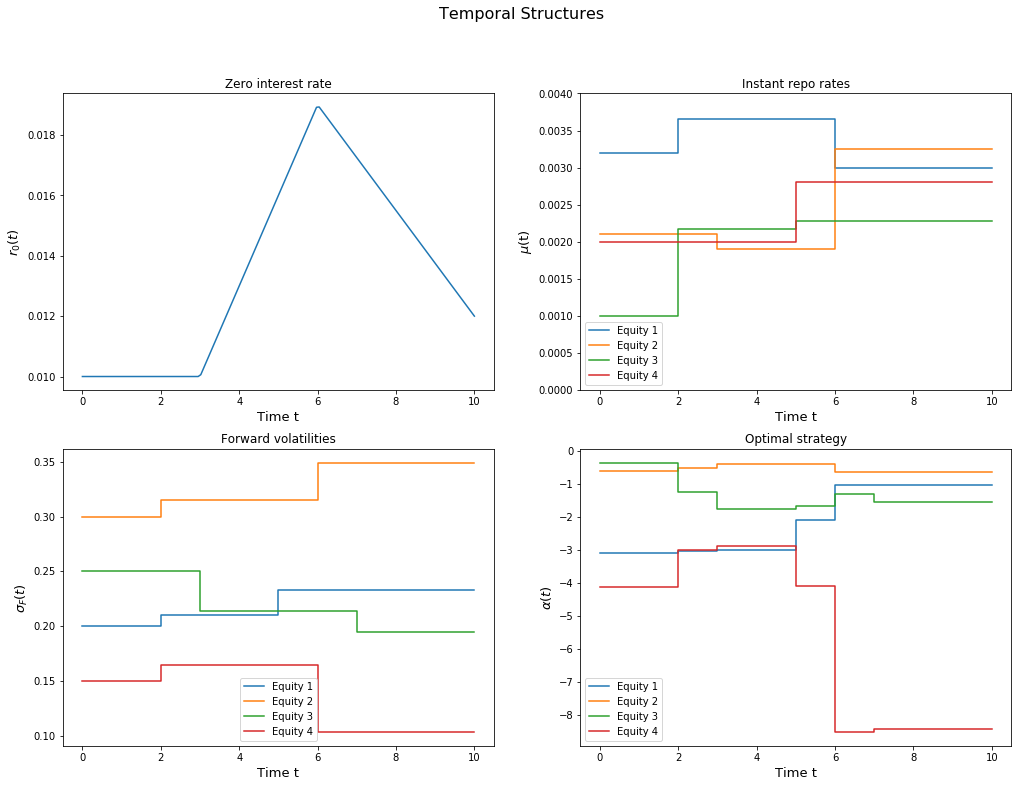

In [6]:
x = np.linspace(0,T_max-0.0001,150)
dimension_points = 15
plt.figure(figsize=(17,12))

plt.suptitle('Temporal Structures',fontsize=16) 

plt.subplot(2,2,1)
plt.plot(x,D.r(x))
plt.title('Zero interest rate')
plt.ylabel("$r_0(t)$", fontsize = 13)
plt.xlabel("Time t", fontsize = 13)
#plt.savefig("Instant_interest_rate.pdf")


plt.subplot(2,2,2)
for i in range(N_equity):
    time = F[i].T.tolist()
    repo = F[i].q.tolist()
    time.insert(0,F[i].T[0])
    time.insert(0,0)
    repo.insert(0,F[i].q[0])
    repo.insert(0,F[i].q[0])
    plt.step(time,repo,label= "Equity "+str(i+1))
plt.legend()
plt.title('Instant repo rates')
plt.xlabel("Time t", fontsize = 13)
plt.ylabel(r"$\mu$(t)", fontsize = 13)
plt.ylim(0,0.004)
#plt.savefig("Instant_repo_rate.pdf")

plt.subplot(2,2,3)
plt.title('Forward volatilities')
for i in range(N_equity):
    time = V[i].T.tolist()
    vola = V[i].forward_vol.tolist()
    time.insert(0,V[i].T[0])
    time.insert(0,0)
    vola.insert(0,V[i].forward_vol[0])
    vola.insert(0,V[i].forward_vol[0])
    plt.step(time,vola,label= "Equity "+str(i+1))
plt.legend()
plt.xlabel("Time t",fontsize = 13)
plt.ylabel(r"$\sigma_{F}(t)$",fontsize = 13)
#plt.savefig("Forward_volatilities.pdf")

plt.subplot(2,2,4)
plt.title("Optimal strategy")
time = alpha.T.tolist()
time.insert(0,alpha.T[0])
time.insert(0,0)
for i in range(N_equity):
    a = alpha.alpha_t.T[i].tolist()
    a.insert(0,alpha.alpha_t.T[i][0])
    a.insert(0,alpha.alpha_t.T[i][0])
    plt.step(time,a,label= "Equity "+str(i+1))
plt.legend()
plt.xlabel("Time t",fontsize=13)
plt.ylabel(r"$\alpha(t)$",fontsize =13)
#plt.savefig("optimal_strategy.pdf")
plt.show()

#### Simulation

In [7]:
I_0 = np.sum(spot_price)
vol_target = 1/N_equity*sqrt(np.sum(nu(0.)@nu(0.).T))
print("Target volatility: ",vol_target)
dates = alpha.T
dates = np.delete(dates,len(alpha.T)-1)
dates = np.append(dates,9.9)
K = I_0   #ATM pricing
simulations = 1e6
kind = 1 #call option
print("Spot price ",I_0)
print("Dates ",dates)

Target volatility:  0.12962089551919187
Spot price  460
Dates  [2.  3.  5.  6.  7.  9.9]


In [9]:
%%time
TVSF = TVSForwardCurve(reference = 0., vola_target =vol_target, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t, forward = TVS.simulate(fixings = dates,Nsim=simulations, seed=13, ret_forward=1)  #10 per euler
pay = Vanilla_PayOff(St=I_t,strike=K, typo=kind)*D(dates)
x, result_mark, result_err_mark = MC_Analisys(pay[:,len(dates)-1],100)

Martingale simulation
Forward calculation
Wall time: 8.8 s


Forward curve at maturity:  536.0716022354245


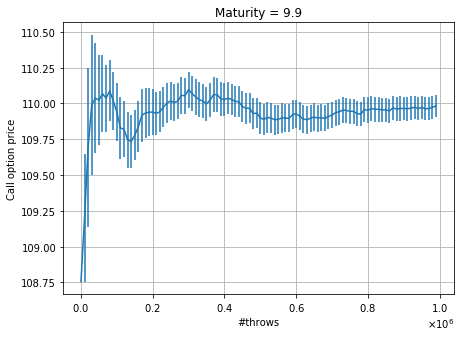

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_mark,yerr=result_err_mark)
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
if kind ==1:
    plt.ylabel("Call option price")
#    plt.savefig("TVS_call_option_price.pdf")
if kind == -1:
    plt.ylabel("Put option price")
#    plt.savefig("TVS_put_option_price.pdf")
print("Forward curve at maturity: ",TVSF(dates[len(dates)-1]))    
plt.show()

Forward curve at maturity:  536.0716022354245


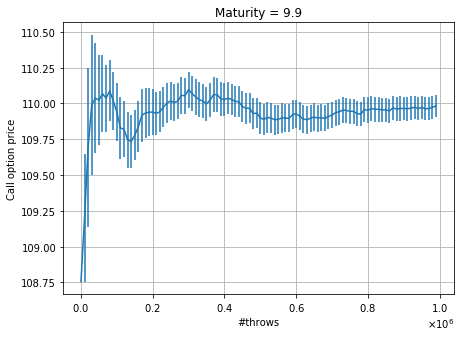

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_mark,yerr=result_err_mark)
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
if kind ==1:
    plt.ylabel("Call option price")
#    plt.savefig("TVS_call_option_price.pdf")
if kind == -1:
    plt.ylabel("Put option price")
#    plt.savefig("TVS_put_option_price.pdf")
print("Forward curve at maturity: ",TVSF(dates[len(dates)-1]))    
plt.show()

C:\Users\Stefano\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


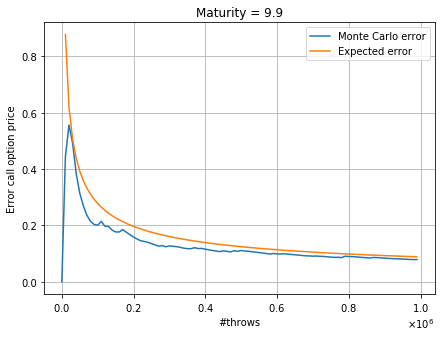

In [12]:
z = np.std(pay.T[len(dates)-1])
y = np.sqrt(x)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.plot(x,result_err_mark, label = 'Monte Carlo error')
plt.plot(x,z/y, label = 'Expected error')
plt.xlabel("#throws")
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
plt.grid(True)
plt.legend()
if kind ==1:
    plt.ylabel("Error call option price")
    #plt.savefig("TVS_call_option_price_error.pdf")
if kind == -1:
    plt.ylabel("Error put option price")
    #plt.savefig("TVS_put_option_price_error.pdf")
plt.show()

In [13]:
n = len(dates)-1
X_t = I_t/forward
N_block = 100
pay_normalized = Vanilla_PayOff(St=X_t,strike=K/forward, typo=kind)
x, result, result_err = MC_Analisys(pay_normalized[:,n],N_block)
imp_volatility_mean = np.zeros(N_block)
imp_volatility_plus = np.zeros(N_block)
imp_volatility_minus = np.zeros(N_block)
print("Calculating implied volatility")
for i in range (N_block):
    imp_volatility_mean[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i],1,K/forward[n],dates[n],kind)
    imp_volatility_plus[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i]+result_err[i],1,K/forward[n],dates[n],kind)
    imp_volatility_minus[i] = lbr.implied_volatility_from_a_transformed_rational_guess(result[i]-result_err[i],1,K/forward[n],dates[n],kind)

print("Error analysis")    
y_lower = np.zeros(N_block)
y_upper = np.zeros(N_block)
for i in range(N_block):
    if(imp_volatility_minus[i]<imp_volatility_plus[i]):
        y_lower[i] = abs(imp_volatility_mean[i]-imp_volatility_minus[i])
        y_upper[i] = abs(imp_volatility_plus[i]-imp_volatility_mean[i])
    elif(imp_volatility_minus[i]>imp_volatility_plus[i]):
        y_lower[i] = abs(imp_volatility[i]-imp_volatility_plus[i])
        y_upper[i] = abs(imp_volatility_minus[i]-imp_volatility_mean[i])


Calculating implied volatility
Error analysis


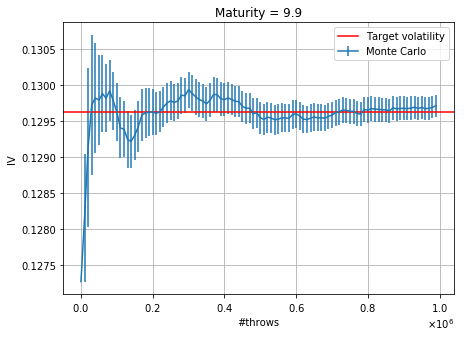

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,imp_volatility_mean,yerr=[y_lower,y_upper], label = "Monte Carlo")
plt.axhline(y=vol_target,color= "red",label = 'Target volatility')
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.ylabel("IV")
plt.legend()
plt.show()

#### Check of the result with Euler integration

In [15]:
n_grid = 500    #grid for the integration of the euler method (6000 for 1e6 good)
dates_euler = np.linspace(0.001,9.9,n_grid)

In [12]:
start_time = time.time()
Eulero = TargetVolatilityEuler(reference = 0., vola_target = vol_target, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0.,T_max]))
I_t = Eulero.simulate(timegrid = dates_euler,Nsim=simulations, seed=10)
pay_euler = Vanilla_PayOff(St=I_t,strike=K,typo=kind)*D(dates_euler[len(dates_euler)-1])
x, result_euler, result_err_euler = MC_Analisys(pay_euler,100)
print("Execution time: ---%s min ---" %((time.time()-start_time)/60))

0
Execution time: ---2.000507203737895 min ---


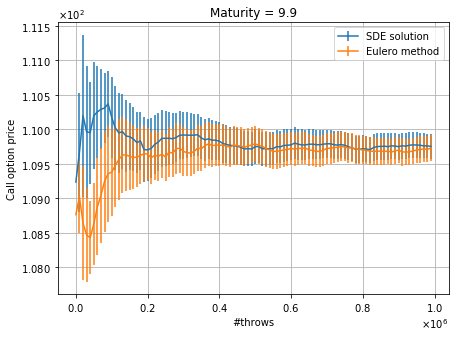

In [13]:
n_sigma = 2
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_mark,yerr=n_sigma*result_err_mark, label = "SDE solution")
plt.errorbar(x,result_euler,yerr=n_sigma*result_err_euler, label = "Eulero method")
plt.xlabel("#throws")
if kind ==1:
    plt.ylabel("Call option price")
if kind == -1:
    plt.ylabel("Put option price")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
plt.legend()
#plt.savefig("Markowitz_convergence_with_euler.pdf")
plt.show()

#### Check with intuitive strategies

In [16]:
%%time
alpha.Intuitive_strategy1(forward_curves=F, maturity_date=T_max)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol_target, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings= dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_intuitive1, result_err_intuitive1 = MC_Analisys(pay[:,len(dates)-1],100)

Strategy time grid:  [ 0 10]
Intuitive strategy (invest all on the asset with maximum growth at maturity)  [[0. 0. 0. 1.]
 [0. 0. 0. 1.]]
Martingale simulation
Forward calculation
Wall time: 8.95 s


In [17]:
%%time
alpha.Intuitive_strategy2(mu=mu)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol_target, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_intuitive2, result_err_intuitive2 = MC_Analisys(pay[:,len(dates)-1],100)

Strategy time grid:  [ 2.  3.  5.  6. 10.]
Intuitive strategy (invest all on the asset with minimum mu parameter) [[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]]
Martingale simulation
Forward calculation
Wall time: 8.96 s


In [18]:
%%time
alpha.Intuitive_strategy3(mu=mu,nu=nu)
TVSF = TVSForwardCurve(reference = 0., vola_target =vol_target, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K)*D(dates)
x, result_intuitive3, result_err_intuitive3 = MC_Analisys(pay[:,len(dates)-1],100)

Strategy time grid:  [ 2.  3.  5.  6.  7. 10.]
Intuitive strategy (invest all on the asset with minimum mu/||nu|| parameter) [[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]
Martingale simulation
Forward calculation
Wall time: 9.21 s


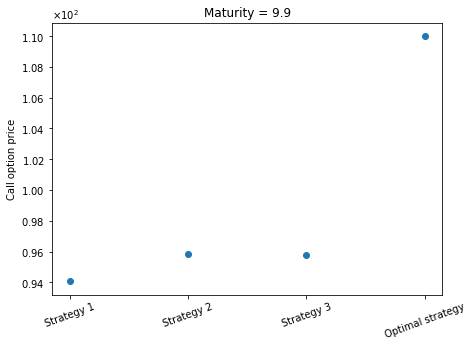

In [19]:
n =len(dates)-1
errori = np.array([result_err_intuitive1[99],result_err_intuitive2[99],result_err_intuitive3[99],result_err_mark[99]])
risultati = err = np.array([result_intuitive1[99],result_intuitive2[99],result_intuitive3[99],result_mark[99]])
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.xticks([1, 2, 3,4], ["Strategy 1","Strategy 2", "Strategy 3", "Optimal strategy"],rotation=20)  # Set text labels and properties.
plt.errorbar([1, 2, 3,4],risultati,errori,fmt='o')
plt.title("Maturity = "+str(round(dates[n],2)))
if kind ==1:
    plt.ylabel("Call option price")
if kind == -1:
    plt.ylabel("Put option price")
ax.yaxis.set_major_formatter(formatter)
#plt.savefig("strategy_comparison.pdf")
plt.show()

#### Price vs target volatility (with optimal strategy)

In [20]:
%%time
volatility_grid = np.arange(1,11)*0.05
alpha.Mark_strategy(mu=mu,nu=nu)
price = np.zeros(len(volatility_grid))
price_error = np.zeros(len(volatility_grid))
for i in range(len(volatility_grid)):
    TVSF = TVSForwardCurve(reference = 0., vola_target =volatility_grid[i], spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
    TVS = TargetVolatilityStrategy(forward_curve=TVSF)
    I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
    pay = Vanilla_PayOff(St=I_t,strike=K, typo=kind)*D(dates)
    price[i],price_error[i] = MC(pay.T[len(dates)-1])   

Markowitz strategy time grid : [ 2.  3.  5.  6.  7. 10.]
Markowitz strategy :  [[-3.08538805 -0.59047171 -0.34529796 -4.11529557]
 [-3.01538728 -0.49479481 -1.23045703 -2.99646247]
 [-2.98585556 -0.38204391 -1.73561309 -2.87740983]
 [-2.06656518 -0.38461624 -1.64383151 -4.07422334]
 [-1.02632803 -0.61780168 -1.2809061  -8.51736088]
 [-1.01784899 -0.61269769 -1.54451194 -8.41249475]]
Martingale simulation
Forward calculation
Martingale simulation
Forward calculation
Martingale simulation
Forward calculation
Martingale simulation
Forward calculation
Martingale simulation
Forward calculation
Martingale simulation
Forward calculation
Martingale simulation
Forward calculation
Martingale simulation
Forward calculation
Martingale simulation
Forward calculation
Martingale simulation
Forward calculation
Wall time: 1min 10s


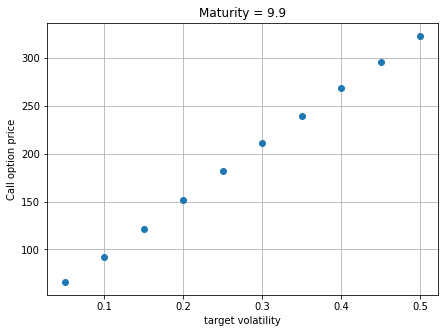

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(volatility_grid,price,yerr=price_error, fmt='o')
plt.xlabel("target volatility")
if kind ==1:
    plt.ylabel("Call option price")
if kind == -1:
    plt.ylabel("Put option price")
plt.grid(True)
#plt.savefig("Markowitz_convergence_with_euler.pdf")
plt.show()

### Constrained optimization

In [22]:
I_0 = np.sum(spot_price)
vol_target = 1/N_equity*sqrt(np.sum(nu(0.)@nu(0.).T))
print("Target volatility: ",vol_target)
dates = alpha.T
dates = np.delete(dates,len(alpha.T)-1)
dates = np.append(dates,9.9)
K = I_0   #ATM pricing
simulations = 1e6
kind = 1 #call option
print("Spot price ",I_0)
print("Dates ",dates)

Target volatility:  0.12962089551919187
Spot price  460
Dates  [2.  3.  5.  6.  7.  9.9]


#### Constraint: 
### $$\sum_i \alpha_i = 1\quad \text{with}\quad \alpha_i>0$$

In [23]:
%%time
alpha.optimization_constrained(mu=mu, nu=nu, typo=1, N_trial=200)

Optimal strategy time grid : [ 2.  3.  5.  6.  7. 10.]
Optimal strategy through minimization:  [[-4.81559237e-15  1.62576116e-16  1.00000000e+00  2.62290190e-15]
 [-1.88737914e-15  1.00000000e+00 -3.10515502e-16 -9.92844587e-16]
 [-2.22044605e-15  1.00000000e+00 -6.49979202e-17  8.68662781e-16]
 [-2.96013214e-14  1.00000000e+00 -1.80216085e-15  7.61272555e-15]
 [-3.15416096e-15  1.00000000e+00 -5.35595873e-17  3.06178694e-16]
 [-1.25767452e-15  1.00000000e+00 -3.58870919e-17  2.02962647e-16]]
Wall time: 11.3 s


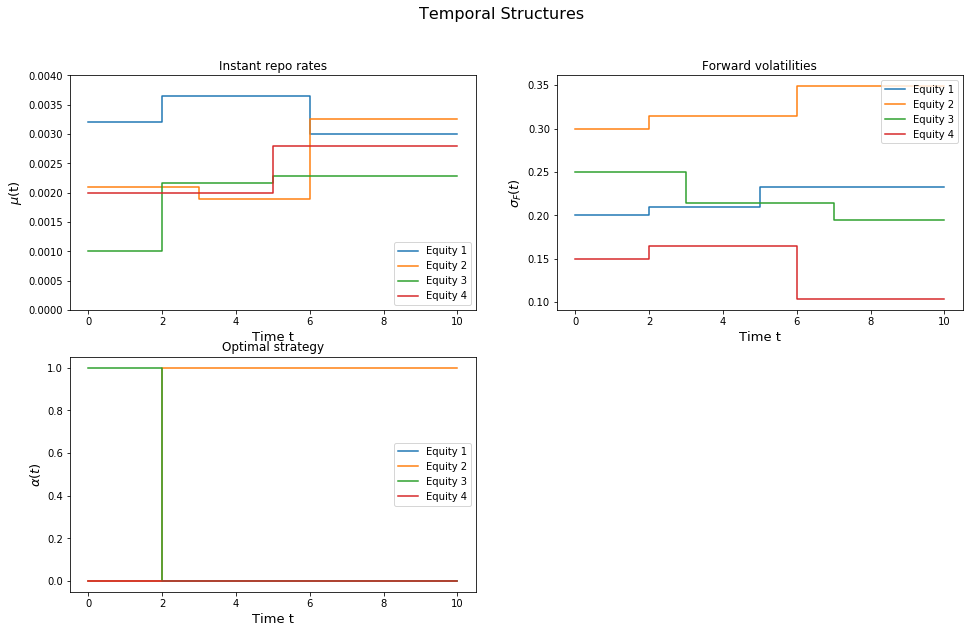

In [24]:
plt.figure(figsize=(16,9.5))
plt.suptitle('Temporal Structures',fontsize=16) 
plt.subplot(2,2,1)
for i in range(N_equity):
    time = F[i].T.tolist()
    repo = F[i].q.tolist()
    time.insert(0,F[i].T[0])
    time.insert(0,0)
    repo.insert(0,F[i].q[0])
    repo.insert(0,F[i].q[0])
    plt.step(time,repo,label= "Equity "+str(i+1))
plt.legend()
plt.title('Instant repo rates')
plt.xlabel("Time t", fontsize = 13)
plt.ylabel(r"$\mu$(t)", fontsize = 13)
plt.ylim(0,0.004)
#plt.savefig("Instant_repo_rate.pdf")

plt.subplot(2,2,2)
plt.title('Forward volatilities')
for i in range(N_equity):
    time = V[i].T.tolist()
    vola = V[i].forward_vol.tolist()
    time.insert(0,V[i].T[0])
    time.insert(0,0)
    vola.insert(0,V[i].forward_vol[0])
    vola.insert(0,V[i].forward_vol[0])
    plt.step(time,vola,label= "Equity "+str(i+1))
plt.legend()
plt.xlabel("Time t",fontsize = 13)
plt.ylabel(r"$\sigma_{F}(t)$",fontsize = 13)
#plt.savefig("Forward_volatilities.pdf")

plt.subplot(2,2,3)
plt.title("Optimal strategy")
time = alpha.T.tolist()
time.insert(0,alpha.T[0])
time.insert(0,0)
for i in range(N_equity):
    a = alpha.alpha_t.T[i].tolist()
    a.insert(0,alpha.alpha_t.T[i][0])
    a.insert(0,alpha.alpha_t.T[i][0])
    plt.step(time,a,label= "Equity "+str(i+1))
plt.legend()
plt.xlabel("Time t",fontsize=13)
plt.ylabel(r"$\alpha(t)$",fontsize =13)
#plt.savefig("optimal_strategy.pdf")
plt.show()

In [25]:
%%time
TVSF = TVSForwardCurve(reference = 0., vola_target =vol_target, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K, typo=kind)*D(dates)
x, result_constrain1, result_err_constrain1 = MC_Analisys(pay[:,len(dates)-1],100)

Martingale simulation
Forward calculation
Wall time: 8.67 s


Forward curve at maturity:  514.2614582039596


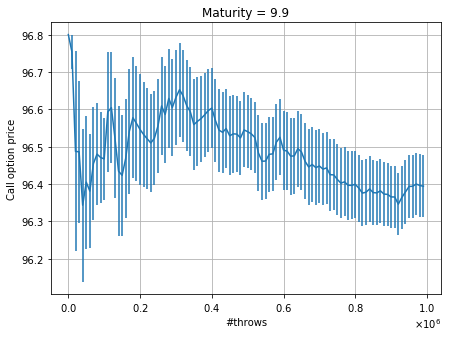

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_constrain1,yerr=result_err_constrain1)
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
if kind ==1:
    plt.ylabel("Call option price")
#    plt.savefig("TVS_call_option_price.pdf")
if kind == -1:
    plt.ylabel("Put option price")
#    plt.savefig("TVS_put_option_price.pdf")
print("Forward curve at maturity: ",TVSF(dates[len(dates)-1]))    
plt.show()

#### Constraint: 
### $$\left|\alpha_i\right| \leq 25\%$$

In [27]:
%%time
alpha.optimization_constrained(mu=mu, nu=nu, typo=2, long_limit=25/100, N_trial=300)

Optimal strategy time grid : [ 2.  3.  5.  6.  7. 10.]
Optimal strategy through minimization:  [[-0.18738902 -0.03590578 -0.02100285 -0.25      ]
 [-0.24539967 -0.04013515 -0.1000502  -0.24389618]
 [-0.2260283  -0.02890069 -0.13141311 -0.21801164]
 [-0.12678989 -0.0236132  -0.10078102 -0.24998716]
 [-0.03013759 -0.01813696 -0.03760344 -0.25      ]
 [-0.03025055 -0.01820793 -0.04590702 -0.25      ]]
Wall time: 14.2 s


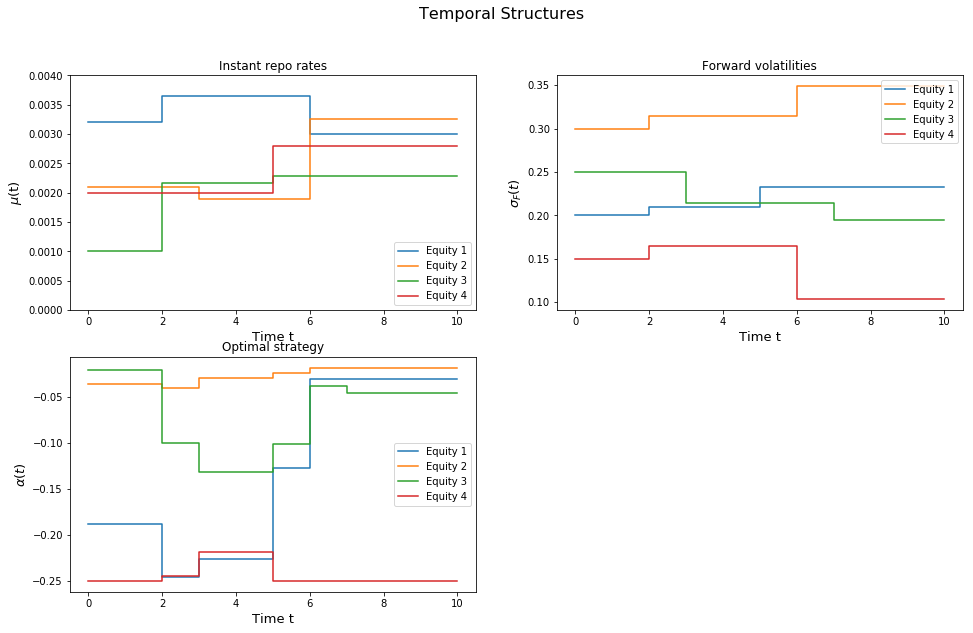

In [28]:
plt.figure(figsize=(16,9.5))
plt.suptitle('Temporal Structures',fontsize=16) 
plt.subplot(2,2,1)
for i in range(N_equity):
    time = F[i].T.tolist()
    repo = F[i].q.tolist()
    time.insert(0,F[i].T[0])
    time.insert(0,0)
    repo.insert(0,F[i].q[0])
    repo.insert(0,F[i].q[0])
    plt.step(time,repo,label= "Equity "+str(i+1))
plt.legend()
plt.title('Instant repo rates')
plt.xlabel("Time t", fontsize = 13)
plt.ylabel(r"$\mu$(t)", fontsize = 13)
plt.ylim(0,0.004)
#plt.savefig("Instant_repo_rate.pdf")

plt.subplot(2,2,2)
plt.title('Forward volatilities')
for i in range(N_equity):
    time = V[i].T.tolist()
    vola = V[i].forward_vol.tolist()
    time.insert(0,V[i].T[0])
    time.insert(0,0)
    vola.insert(0,V[i].forward_vol[0])
    vola.insert(0,V[i].forward_vol[0])
    plt.step(time,vola,label= "Equity "+str(i+1))
plt.legend()
plt.xlabel("Time t",fontsize = 13)
plt.ylabel(r"$\sigma_{F}(t)$",fontsize = 13)
#plt.savefig("Forward_volatilities.pdf")

plt.subplot(2,2,3)
plt.title("Optimal strategy")
time = alpha.T.tolist()
time.insert(0,alpha.T[0])
time.insert(0,0)
for i in range(N_equity):
    a = alpha.alpha_t.T[i].tolist()
    a.insert(0,alpha.alpha_t.T[i][0])
    a.insert(0,alpha.alpha_t.T[i][0])
    plt.step(time,a,label= "Equity "+str(i+1))
plt.legend()
plt.xlabel("Time t",fontsize=13)
plt.ylabel(r"$\alpha(t)$",fontsize =13)
#plt.savefig("optimal_strategy.pdf")
plt.show()

In [29]:
%%time
TVSF = TVSForwardCurve(reference = 0., vola_target =vol_target, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K, typo=kind)*D(dates)
x, result_constrain2, result_err_constrain2 = MC_Analisys(pay[:,len(dates)-1],100)

Martingale simulation
Forward calculation
Wall time: 8.87 s


Forward curve at maturity:  536.0716017423424


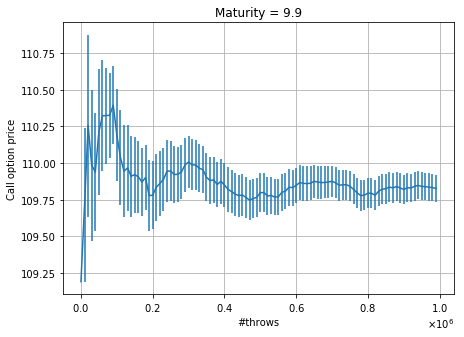

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_constrain2,yerr=result_err_constrain2)
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
if kind ==1:
    plt.ylabel("Call option price")
#    plt.savefig("TVS_call_option_price.pdf")
if kind == -1:
    plt.ylabel("Put option price")
#    plt.savefig("TVS_put_option_price.pdf")
print("Forward curve at maturity: ",TVSF(dates[len(dates)-1]))    
plt.show()

#### Constraint: 
### $$\sum_i\alpha_i \leq 90\% \quad \text{for} \quad \alpha_i>0$$
### $$\left|\sum_i\alpha_i \right| \leq 10\% \quad \text{for} \quad \alpha_i<0$$

In [31]:
%%time
alpha.optimization_constrained(mu=mu, nu=nu, typo=3, long_limit=90/100,short_limit=10/100, N_trial=200)

Optimal strategy time grid : [ 2.  3.  5.  6.  7. 10.]
Optimal strategy through minimization:  [[-0.02522098 -0.00482968 -0.00281223 -0.03362022]
 [-0.03895019 -0.0064046  -0.01590939 -0.03873583]
 [-0.03742428 -0.00478433 -0.02174599 -0.03604541]
 [-0.02529624 -0.00471111 -0.02012364 -0.04986902]
 [-0.00896981 -0.00539982 -0.0111937  -0.07443668]
 [-0.00878381 -0.00528808 -0.01332804 -0.07260008]]
Wall time: 43.5 s


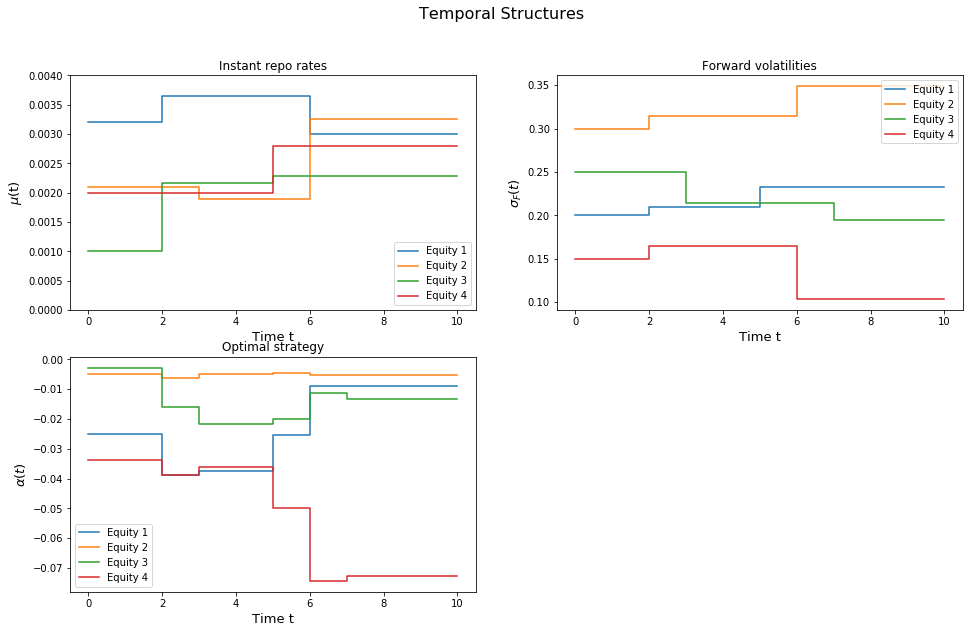

In [32]:
plt.figure(figsize=(16,9.5))
plt.suptitle('Temporal Structures',fontsize=16) 
plt.subplot(2,2,1)
for i in range(N_equity):
    time = F[i].T.tolist()
    repo = F[i].q.tolist()
    time.insert(0,F[i].T[0])
    time.insert(0,0)
    repo.insert(0,F[i].q[0])
    repo.insert(0,F[i].q[0])
    plt.step(time,repo,label= "Equity "+str(i+1))
plt.legend()
plt.title('Instant repo rates')
plt.xlabel("Time t", fontsize = 13)
plt.ylabel(r"$\mu$(t)", fontsize = 13)
plt.ylim(0,0.004)
#plt.savefig("Instant_repo_rate.pdf")

plt.subplot(2,2,2)
plt.title('Forward volatilities')
for i in range(N_equity):
    time = V[i].T.tolist()
    vola = V[i].forward_vol.tolist()
    time.insert(0,V[i].T[0])
    time.insert(0,0)
    vola.insert(0,V[i].forward_vol[0])
    vola.insert(0,V[i].forward_vol[0])
    plt.step(time,vola,label= "Equity "+str(i+1))
plt.legend()
plt.xlabel("Time t",fontsize = 13)
plt.ylabel(r"$\sigma_{F}(t)$",fontsize = 13)
#plt.savefig("Forward_volatilities.pdf")

plt.subplot(2,2,3)
plt.title("Optimal strategy")
time = alpha.T.tolist()
time.insert(0,alpha.T[0])
time.insert(0,0)
for i in range(N_equity):
    a = alpha.alpha_t.T[i].tolist()
    a.insert(0,alpha.alpha_t.T[i][0])
    a.insert(0,alpha.alpha_t.T[i][0])
    plt.step(time,a,label= "Equity "+str(i+1))
plt.legend()
plt.xlabel("Time t",fontsize=13)
plt.ylabel(r"$\alpha(t)$",fontsize =13)
#plt.savefig("optimal_strategy.pdf")
plt.show()

In [33]:
%%time
TVSF = TVSForwardCurve(reference = 0., vola_target =vol_target, spot_price = I_0, strategy = alpha, mu = mu,nu = nu, discounting_curve = D, fees = np.array([0,0]), fees_dates = np.array([0,T_max]))
TVS = TargetVolatilityStrategy(forward_curve=TVSF)
I_t = TVS.simulate(fixings = dates,Nsim=simulations, seed=10)
pay = Vanilla_PayOff(St=I_t,strike=K, typo=kind)*D(dates)
x, result_constrain3, result_err_constrain3 = MC_Analisys(pay[:,len(dates)-1],100)

Martingale simulation
Forward calculation
Wall time: 8.89 s


Forward curve at maturity:  536.0716018237644


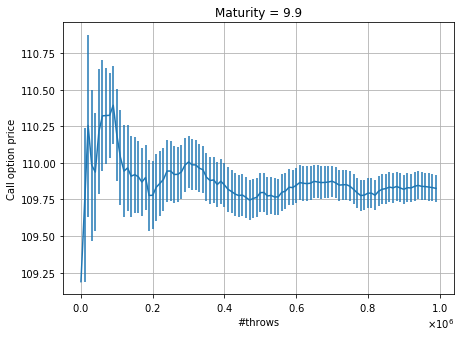

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
plt.title("Maturity = "+str(round(dates[len(dates)-1],2)))
plt.errorbar(x,result_constrain3,yerr=result_err_constrain3)
plt.xlabel("#throws")
formatter = ticker.ScalarFormatter(useMathText=True) #scientific notation
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.xaxis.set_major_formatter(formatter)
#ax.yaxis.set_major_formatter(formatter)
plt.grid(True)
if kind ==1:
    plt.ylabel("Call option price")
#    plt.savefig("TVS_call_option_price.pdf")
if kind == -1:
    plt.ylabel("Put option price")
#    plt.savefig("TVS_put_option_price.pdf")
print("Forward curve at maturity: ",TVSF(dates[len(dates)-1]))    
plt.show()